In [88]:
import tensorflow as tf
import tensorflowjs as tfjs
from maml import MAML
from model import Model
from tasks import SinusoidRegressionTaskDistribution
from reptile import Reptile
import numpy as np
import matplotlib.pyplot as plt
from deployable import DeployableModel
from functools import partial
from pretrained import PretrainedModel
import time

#### Inspiration have been taken from:
# https://github.com/luis-mueller/maml-tf2/blob/main/README.md
# https://github.com/greentfrapp/maml-reptile/blob/b45520c322d8ad1a4a7214e37cfc6f9b8b363658/README.md
# https://github.com/resibots/kaushik_2020_famle
# https://github.com/openai/supervised-reptile
# https://towardsdatascience.com/paper-repro-deep-metalearning-using-maml-and-reptile-fd1df1cc81b0
# https://colab.research.google.com/github/mari-linhares/tensorflow-maml/blob/master/maml.ipynb


#is gpu available?
print("GPU Available: ", tf.test.is_gpu_available())
#which cuda version?
print("CUDA Version:", tf.test.is_built_with_cuda())
#which tensorflow version?  
print("Tensorflow version:", tf.__version__)
#which tensorflowjs version?
print("Tensorflowjs version:", tfjs.__version__)
#which keras version?
print("Keras version:", tf.keras.__version__)




GPU Available:  True
CUDA Version: True
Tensorflow version: 2.18.0
Tensorflowjs version: 4.22.0
Keras version: 3.7.0


I0000 00:00:1734344561.407675  139735 gpu_device.cc:2022] Created device /device:GPU:0 with 5582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


# Comparison of Meta-Learning and Transfer-Learning

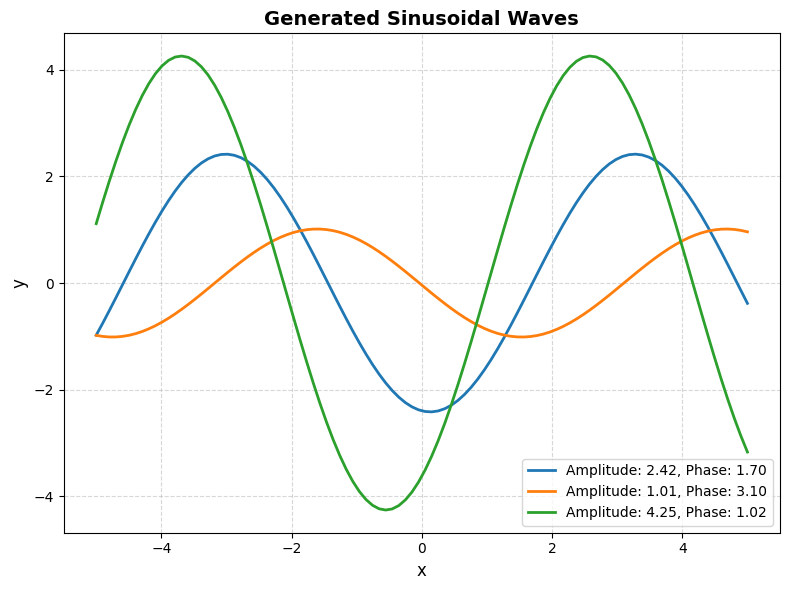

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_sinusoidal_waves(task_distribution, num_waves=3, x_range=(-5, 5), num_points=100):
    """Generate and plot sinusoidal waves with random amplitudes and phases."""
    x = np.linspace(*x_range, num_points)  # Generate x values
    plt.figure(figsize=(8, 6))

    for _ in range(num_waves):
        task = task_distribution.sampleTask()
        y = task(x)  # Evaluate the sine wave
        plt.plot(x, y, label=f"Amplitude: {task.amplitude.numpy()[0]:.2f}, Phase: {task.phase.numpy()[0]:.2f}", linewidth=2)

    # Styling
    plt.title("Generated Sinusoidal Waves", fontsize=14, fontweight='bold')
    plt.xlabel("x", fontsize=12)
    plt.ylabel("y", fontsize=12)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# Example usage
task_distribution = SinusoidRegressionTaskDistribution()
plot_sinusoidal_waves(task_distribution)


The picture over is a plot of three sinusoidal waves with random amplitudes and phases. The task distribution is generated by the SinusoidRegressionTaskDistribution class, which samples tasks with random amplitudes and phases. The plot shows the x values on the x-axis and the y values on the y-axis. Each wave is labeled with its amplitude and phase values.

## Transfere-Learning

In [203]:
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from tensorflow.keras.utils import register_keras_serializable


import tensorflow as tf
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()  # Register the class for serialization
class PretrainModel(tf.keras.Model):
    def __init__(self, trainable=True, dtype="float32"):
        super().__init__()
        self.hidden1 = tf.keras.layers.Dense(40, activation='relu', dtype=dtype, trainable=trainable)
        self.hidden2 = tf.keras.layers.Dense(40, activation='relu', dtype=dtype, trainable=trainable)
        self.out = tf.keras.layers.Dense(1, dtype=dtype, trainable=trainable)

    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

    def call(self, inputs, training=None):
        return self.forward(inputs)

    def get_config(self):
        # Include any arguments needed for reconstruction
        return {
            "trainable": self.trainable,
            "dtype": self.dtype_policy.name,
        }

    @classmethod
    def from_config(cls, config):
        # Create an instance of the class from its config
        return cls(**config)


@tf.function
def loss_function(y_true, y_pred):
    return tf.reduce_mean(tf.math.squared_difference(y_true, y_pred))

def compute_loss(model, x, y, loss_fn):
    predictions = model.forward(x)
    loss = loss_fn(y, predictions)
    return loss, predictions

def compute_gradients(model, x, y, loss_fn):
    with tf.GradientTape() as tape:
        loss, _ = compute_loss(model, x, y, loss_fn)
    gradients = tape.gradient(loss, model.trainable_variables)
    return gradients, loss

def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))

def train_batch(x, y, model, optimizer, loss_fn):
    gradients, loss = compute_gradients(model, x, y, loss_fn)
    apply_gradients(optimizer, gradients, model.trainable_variables)
    return loss

def pretrain_model(task_distribution, epochs=5, nSamples=10, nTasks=25, nBatch=1000, lr=0.001, log_steps=100):
    model = PretrainModel()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # Build the model by calling it once with dummy data
    dummy_input = tf.zeros((1, 1))
    model.forward(dummy_input)  # Ensure the model is initialized

    print("Pre-training the model...")
    start_time = time.time()
    losses = []

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx in range(nBatch):
            x_train, y_train = [], []
            for _ in range(nTasks):
                task = task_distribution.sampleTask()
                x, y = task.sampleFromTask(nSamples)
                x_train.append(x)
                y_train.append(y)

            # Combine task data into a single batch
            x_train = tf.concat(x_train, axis=0)
            y_train = tf.concat(y_train, axis=0)

            # Train on the batch
            batch_loss = train_batch(x_train, y_train, model, optimizer, loss_function)
            total_loss += batch_loss
            curr_loss = total_loss / (batch_idx + 1.0)
            losses.append(curr_loss.numpy())  # Convert to NumPy for logging

            # Log progress at intervals
            if batch_idx % log_steps == 0:
                print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}/{nBatch}, Loss: {curr_loss.numpy():.4f}")

        # Log epoch results
        avg_loss = total_loss / nBatch
        print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {avg_loss.numpy():.4f}")

    # Plot loss over time
    plt.plot(losses)
    plt.title('Loss vs. Training Steps')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.show()

    end_time = time.time()
    print(f"Pre-training completed in {end_time - start_time:.2f} seconds")
    return model

Pre-training the model...
Epoch 1, Batch 1/1000, Loss: 9.0031
Epoch 1, Batch 101/1000, Loss: 8.3559
Epoch 1, Batch 201/1000, Loss: 8.3703
Epoch 1, Batch 301/1000, Loss: 8.3691
Epoch 1, Batch 401/1000, Loss: 8.3715
Epoch 1, Batch 501/1000, Loss: 8.3575
Epoch 1, Batch 601/1000, Loss: 8.3592
Epoch 1, Batch 701/1000, Loss: 8.3541
Epoch 1, Batch 801/1000, Loss: 8.3543
Epoch 1, Batch 901/1000, Loss: 8.3574
Epoch 1/5, Average Loss: 8.3576
Epoch 2, Batch 1/1000, Loss: 8.0363
Epoch 2, Batch 101/1000, Loss: 8.3415
Epoch 2, Batch 201/1000, Loss: 8.3151
Epoch 2, Batch 301/1000, Loss: 8.3252
Epoch 2, Batch 401/1000, Loss: 8.3162
Epoch 2, Batch 501/1000, Loss: 8.3307
Epoch 2, Batch 601/1000, Loss: 8.3298
Epoch 2, Batch 701/1000, Loss: 8.3388
Epoch 2, Batch 801/1000, Loss: 8.3476
Epoch 2, Batch 901/1000, Loss: 8.3435
Epoch 2/5, Average Loss: 8.3452
Epoch 3, Batch 1/1000, Loss: 8.2410
Epoch 3, Batch 101/1000, Loss: 8.2500
Epoch 3, Batch 201/1000, Loss: 8.2765
Epoch 3, Batch 301/1000, Loss: 8.2984
Epoc

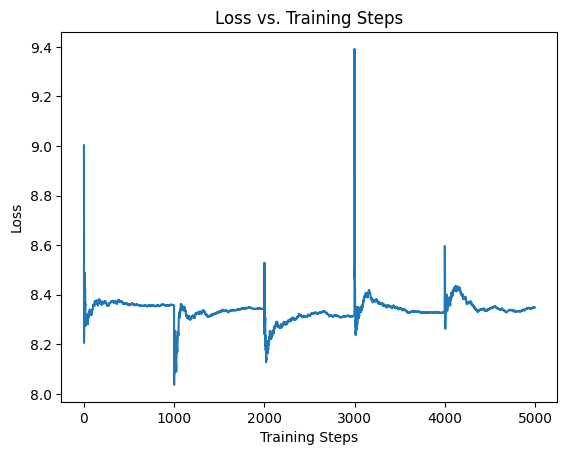

Pre-training completed in 491.31 seconds


In [204]:
# Task distribution
task_distribution = SinusoidRegressionTaskDistribution()

# Pre-train the model
pretrained_model = pretrain_model(task_distribution)

The model have been thuned on different tasks and amount to see if the preformance got better and it did not.

The model is was trained for a longer time, but because of no imporvement, it was dicedd that we boke it of. Under is a picture of the loss values after 30 epohs. The we have in the jupyter file MetaTesting made neural network but with equally speaced points, and that managed to do it a bit better, and diverged to 3.
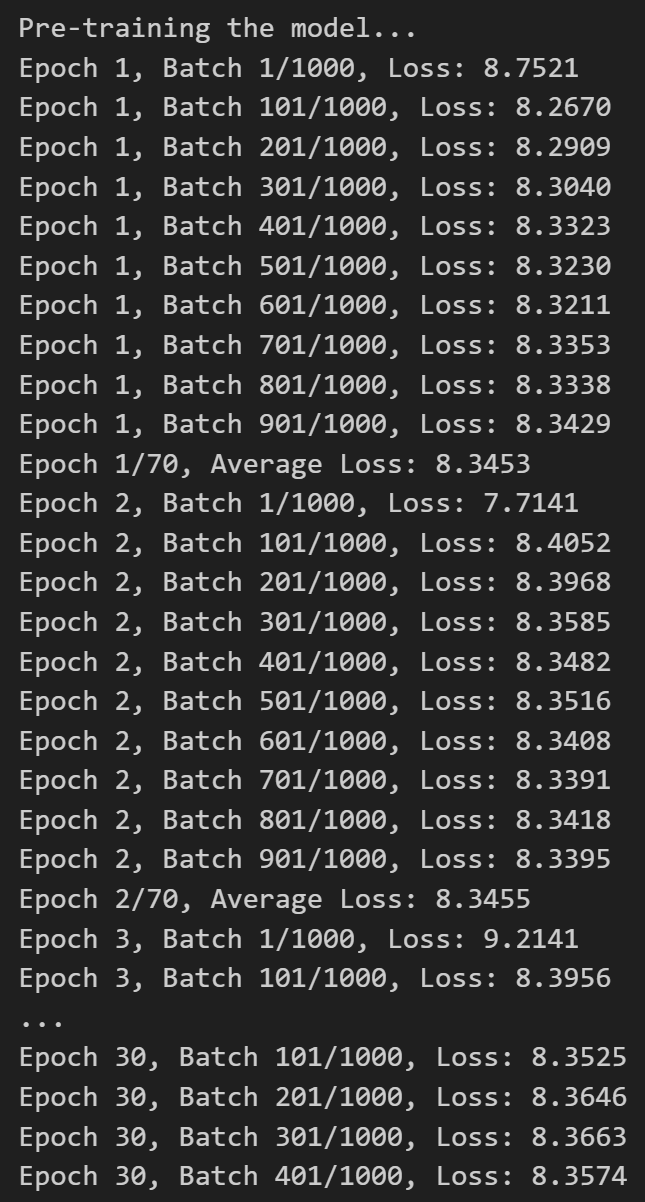

In [208]:
#pretrained_model.save('/home/kristmro/workspace/MetaLearningCodes/TestingSin/savedModels/pre_trained.keras')

/home/kristmro/workspace/MetaLearningCodes/TestingSin/venv/lib/python3.9/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [209]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Evaluate the loss
def evaluate_loss(model, x, y):
    predictions = model(x)
    loss = tf.keras.losses.MeanSquaredError()(y, predictions)
    return loss, predictions

# Evaluate the model on a sine wave task
def eval_sine_test(model, x, y, x_test, y_test, num_steps=(0, 1, 10)):
    fit_res = []
    tensor_x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
    tensor_y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

    # Evaluate loss before any training
    if 0 in num_steps:
        loss, logits = evaluate_loss(model, tensor_x_test, tensor_y_test)
        fit_res.append((0, logits.numpy(), loss.numpy()))

    # Train for specified steps
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    for step in range(1, max(num_steps) + 1):
        with tf.GradientTape() as tape:
            predictions = model(tf.convert_to_tensor(x, dtype=tf.float32))
            loss = tf.keras.losses.MeanSquaredError()(tf.convert_to_tensor(y, dtype=tf.float32), predictions)
        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        loss, logits = evaluate_loss(model, tensor_x_test, tensor_y_test)
        if step in num_steps:
            fit_res.append((step, logits.numpy(), loss.numpy()))

    return fit_res

def eval_sinewave_for_test(model_path, task, num_steps=(0, 1, 10), plot=True):
    """Evaluate the model's performance on a sine wave task.
    
    Args:
        model_path: Path to the pre-trained model in .keras format.
        task: An instance of SinusoidRegressionTask.
        num_steps: List of training steps to evaluate.
        plot: Whether to plot the results.
        
    Returns:
        Fit results: A list of step, predictions, and loss for each evaluation step.
    """
    # Generate training and test data from the task
    x_train = tf.random.uniform((10, 1), -5.0, 5.0)  # Random x-values for training
    y_train = task(x_train)  # Generate corresponding y-values on the curve
    x_test = tf.linspace(-5.0, 5.0, 100)[:, None]  # Smooth range of x-values for testing
    y_test = task(x_test)  # Generate corresponding y-values on the curve

    # Load the model from .keras file
    model = tf.keras.models.load_model(model_path)

    # Clone the model for evaluation
    copied_model = tf.keras.models.clone_model(model)
    copied_model.set_weights(model.get_weights())

    # Evaluate and train
    fit_res = eval_sine_test(copied_model, x_train, y_train, x_test, y_test, num_steps)

    # Plot results
    if plot:
        plt.scatter(x_train, y_train, color='red', label='Training Points')
        plt.plot(x_test, y_test, label='True Function', color='blue')
        for step, logits, _ in fit_res:
            plt.plot(x_test, logits[:, 0], '--', label=f'After {step} Steps')
        plt.legend()
        plt.ylim(-5, 5)
        plt.xlim(-6, 6)
        plt.title("Model Fine-tuning on New Sine Wave")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.show()

    return fit_res



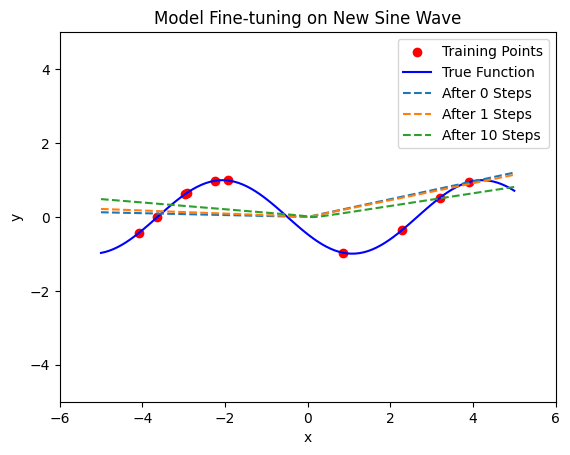

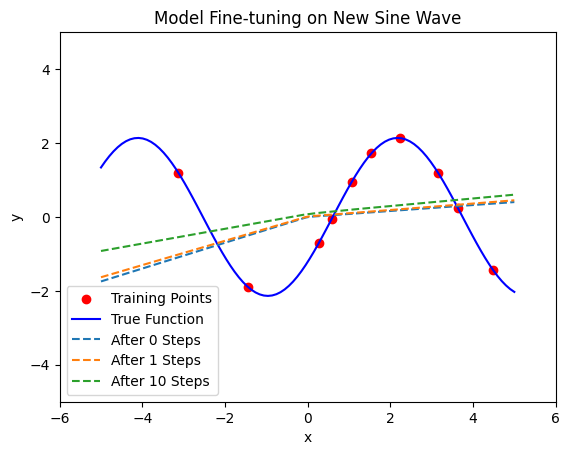

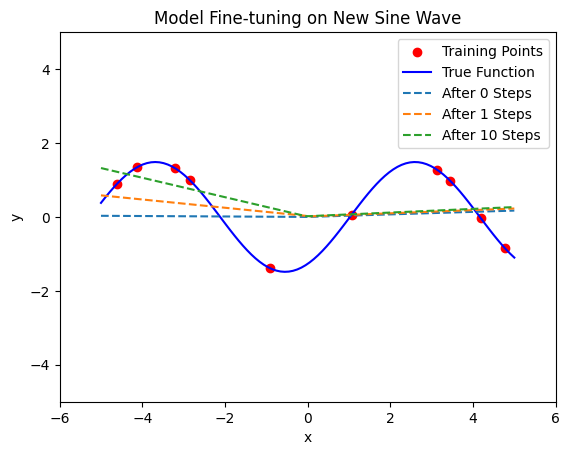

In [210]:
# Testing the pretrained model on the function eval_sinewave_for_test
pre_model_path = '/home/kristmro/workspace/MetaLearningCodes/TestingSin/savedModels/pre_trained.keras'
# Evaluate and plot for 3 random tasks
for _ in range(3):
    task = task_distribution.sampleTask()
    eval_sinewave_for_test(pre_model_path, task)



In [97]:
#Making the different models
#!python3 ground/test.py maml-reproduce maml --epochs=70 --batch-size=1000 --training-tasks=25 --task-sample=10 --save-preliminary True
#!python3 ground/test.py fomaml-reproduce fomaml --epochs=70 --batch-size=1000 --training-tasks=25 --task-sample=10 --save-preliminary True




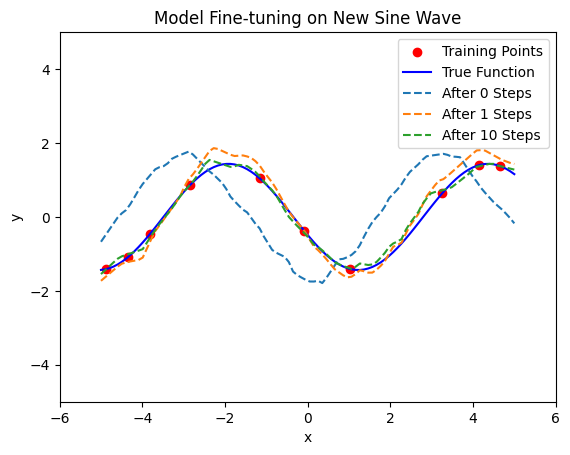

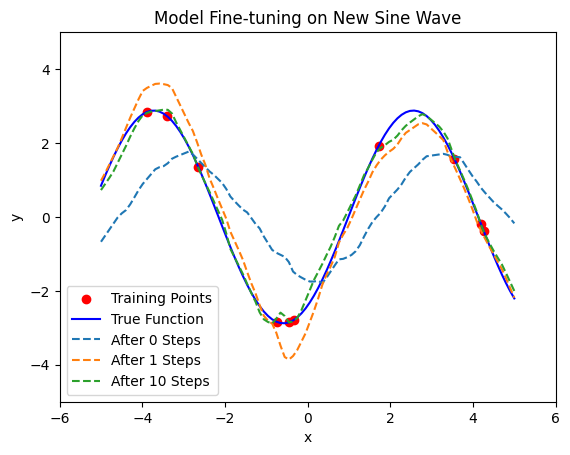

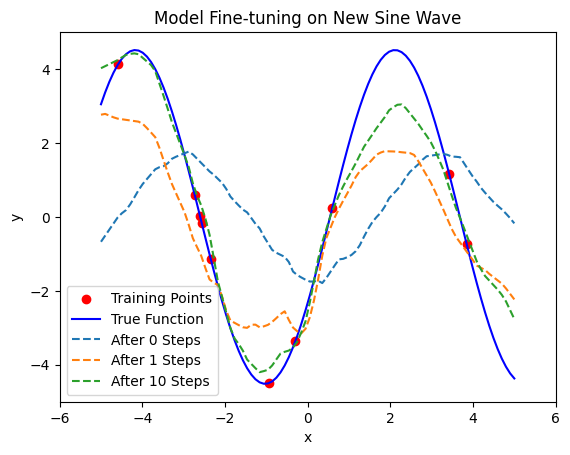

In [98]:
# Example usage:
task_distribution = SinusoidRegressionTaskDistribution()
model_path = '/home/kristmro/workspace/MetaLearningCodes/TestingSin/savedModels/maml-reproduce.keras'

# Evaluate and plot for 3 random tasks
for _ in range(3):
    task = task_distribution.sampleTask()
    eval_sinewave_for_test(model_path, task)


In [53]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def compute_stepwise_loss(models, task, max_steps=10):
    """Compute the loss at each gradient step for multiple models.
    
    Args:
        models: List of tuples (model_name, model_path) to evaluate.
        task: An instance of SinusoidRegressionTask.
        max_steps: The maximum number of gradient steps to evaluate.
    
    Returns:
        A dictionary mapping model names to their stepwise losses.
    """
    # Generate training and test data
    x_train = tf.random.uniform((10, 1), -5.0, 5.0)  # Random x-values for training
    y_train = task(x_train)  # Corresponding y-values
    x_test = tf.linspace(-5.0, 5.0, 100)[:, None]
    y_test = task(x_test)  # Ground truth for the sine wave

    # Loss function
    loss_fn = tf.keras.losses.MeanSquaredError()

    # Results container
    all_losses = {}

    # Loop through each model
    
    for model_name, model_path in models:
        print(f"Evaluating {model_name}...")
        model = tf.keras.models.load_model(model_path)

        # Clone model to avoid overwriting weights
        copied_model = tf.keras.models.clone_model(model)
        copied_model.set_weights(model.get_weights())

        # Optimizer
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

        # Store losses at each step
        step_losses = []

        for step in range(max_steps + 1):
            # Compute loss on test data
            test_loss = loss_fn(y_test, copied_model(x_test)).numpy()
            step_losses.append(test_loss)

            # Perform a gradient step on training data
            if step < max_steps:
                with tf.GradientTape() as tape:
                    predictions = copied_model(x_train)
                    loss = loss_fn(y_train, predictions)
                gradients = tape.gradient(loss, copied_model.trainable_weights)
                optimizer.apply_gradients(zip(gradients, copied_model.trainable_weights))

        all_losses[model_name] = step_losses

    return all_losses

def plot_model_comparisons(losses_dict, max_steps=10):
    """Plot the stepwise losses for multiple models.
    
    Args:
        losses_dict: A dictionary mapping model names to their losses.
        max_steps: The number of gradient steps.
    """
    plt.figure(figsize=(8, 6))
    for model_name, losses in losses_dict.items():
        plt.plot(range(max_steps + 1), losses, label=model_name, marker='o')
    
    plt.title("Loss Comparison Across Gradient Steps")
    plt.xlabel("Gradient Steps")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)
    plt.show()



Evaluating MAML...
Evaluating FOMAML...
Evaluating Basline...


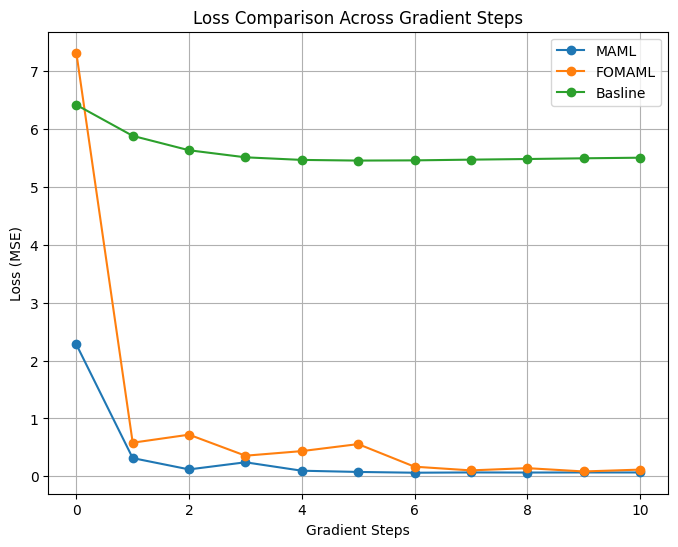

In [117]:
# Example usage
task_distribution = SinusoidRegressionTaskDistribution()
task = task_distribution.sampleTask()

# List of models: (model_name, model_path)
models = [
    ("MAML", "/home/kristmro/workspace/MetaLearningCodes/TestingSin/savedModels/maml-reproduce.keras"),
    ("FOMAML", "/home/kristmro/workspace/MetaLearningCodes/TestingSin/savedModels/fomaml-reproduce.keras"),
    ("Basline", "/home/kristmro/workspace/MetaLearningCodes/TestingSin/savedModels/model.keras"),
]

# Compute losses
stepwise_losses = compute_stepwise_loss(models, task, max_steps=10)

# Plot the losses
plot_model_comparisons(stepwise_losses, max_steps=10)


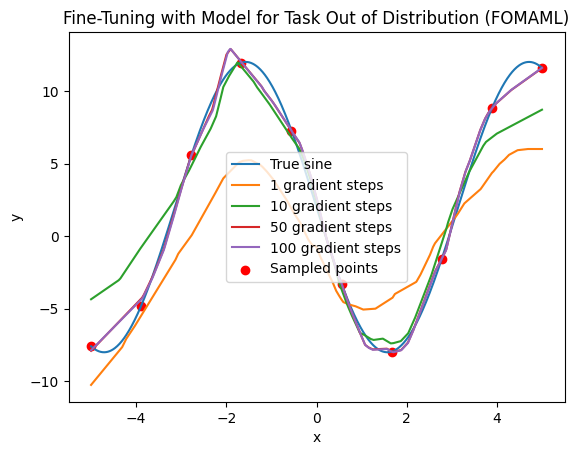

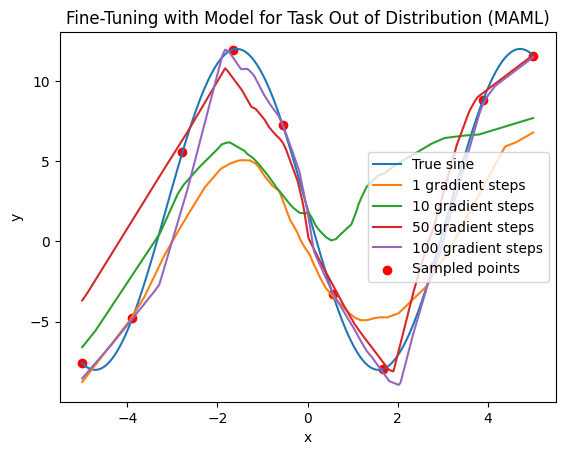

In [224]:
def fine_tune_and_plot(model, task, n_steps_list=[1, 10, 50, 100], learning_rate=0.01, name='model'):
    """
    Fine-tune the given model on a specified task and plot the results.

    Args:
        model: The pre-trained model to fine-tune.
        task: The task function to evaluate.
        n_steps_list: List of gradient steps to perform for fine-tuning.
        learning_rate: Learning rate for fine-tuning.
    """
    # Generate training data points (xs, ys)
    xs = tf.reshape(tf.linspace(-5., 5., 10), (10, 1))  # 10 sample points
    ys = task(xs)

    # Generate points for the true sine function
    x = tf.reshape(tf.linspace(-5., 5., 1000), (1000, 1))  # 1000 points for plotting
    plt.plot(x, task(x), label="True sine")

    # Define a custom loss function (Mean Squared Error)
    loss_fn = tf.keras.losses.MeanSquaredError()

    # Fine-tuning loop
    for n_steps in n_steps_list:
        # Clone model to avoid overwriting weights
        copied_model = tf.keras.models.clone_model(model)
        copied_model.set_weights(model.get_weights())

        # Optimizer
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

        # Perform fine-tuning steps
        for step in range(n_steps):
            with tf.GradientTape() as tape:
                # Compute the loss on the current task
                predictions = copied_model(xs)
                loss = loss_fn(ys, predictions)

            # Compute gradients
            grads = tape.gradient(loss, copied_model.trainable_weights)

            # Apply gradients to update the weights
            optimizer.apply_gradients(zip(grads, copied_model.trainable_weights))

        # Make predictions with updated weights
        predictions = copied_model(x)

        # Plot the predictions
        plt.plot(x, predictions, label=f"{n_steps} gradient steps")

    # Plot the training points
    plt.scatter(xs, ys, color='red', label='Sampled points')

    # Finalize the plot
    plt.title('Fine-Tuning with Model for Task Out of Distribution ('+name+')') 
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

# usage
model_path = '/home/kristmro/workspace/MetaLearningCodes/TestingSin/savedModels/fomaml-reproduce.keras'
model = tf.keras.models.load_model(model_path)
task = lambda x: 10 * tf.sin(x + 3 * np.pi)+2
fine_tune_and_plot(model, task, name='FOMAML')

model_path = '/home/kristmro/workspace/MetaLearningCodes/TestingSin/savedModels/maml-reproduce.keras'
model = tf.keras.models.load_model(model_path)
task = lambda x: 10 * tf.sin(x + 3 * np.pi)+2
fine_tune_and_plot(model, task, name='MAML')

Fomaml seems to be more fitting for out of disrubution tasks. Under one can also see that the maml can get unstable when introduced to scertain out of distrubtuion tasks. This is an important discovery for further investigations and work. This could also be appart of the discussion, that the two meta learning algortihms where trained on differnt task distrubutions, and therefor Fomaml might be (as it seems also from the zero gradient step tuning plot) trained on more close to the limit tasks. 

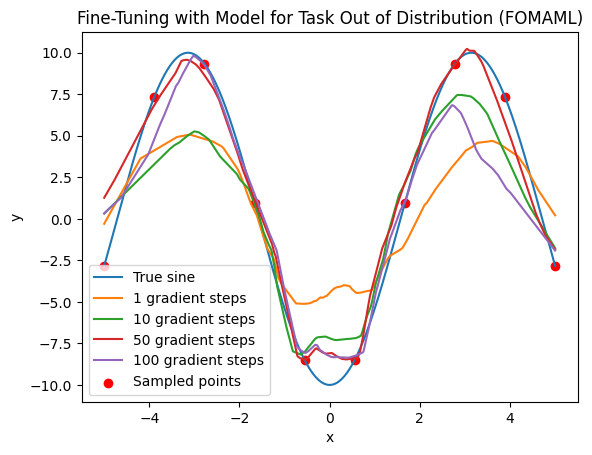

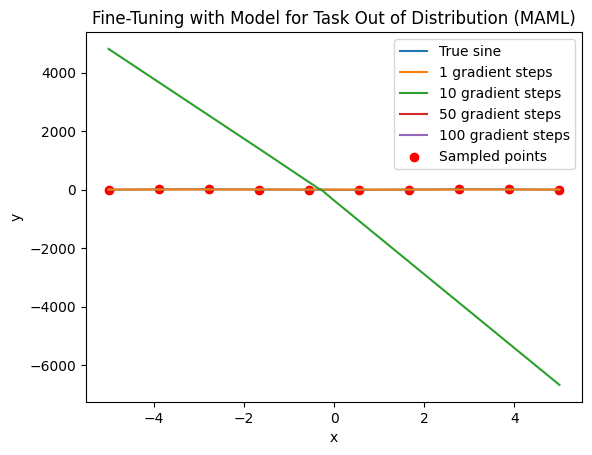

In [223]:
model_path = '/home/kristmro/workspace/MetaLearningCodes/TestingSin/savedModels/fomaml-reproduce.keras'
model = tf.keras.models.load_model(model_path)
task = lambda x: 10 * tf.sin(x + 3/2 * np.pi)
fine_tune_and_plot(model, task, name='FOMAML')

model_path = '/home/kristmro/workspace/MetaLearningCodes/TestingSin/savedModels/maml-reproduce.keras'
model = tf.keras.models.load_model(model_path)
task = lambda x: 10 * tf.sin(x + 3/2 * np.pi)
fine_tune_and_plot(model, task, name='MAML')

Evaluating MAML...
Evaluating FOMAML...
Evaluating Baseline...


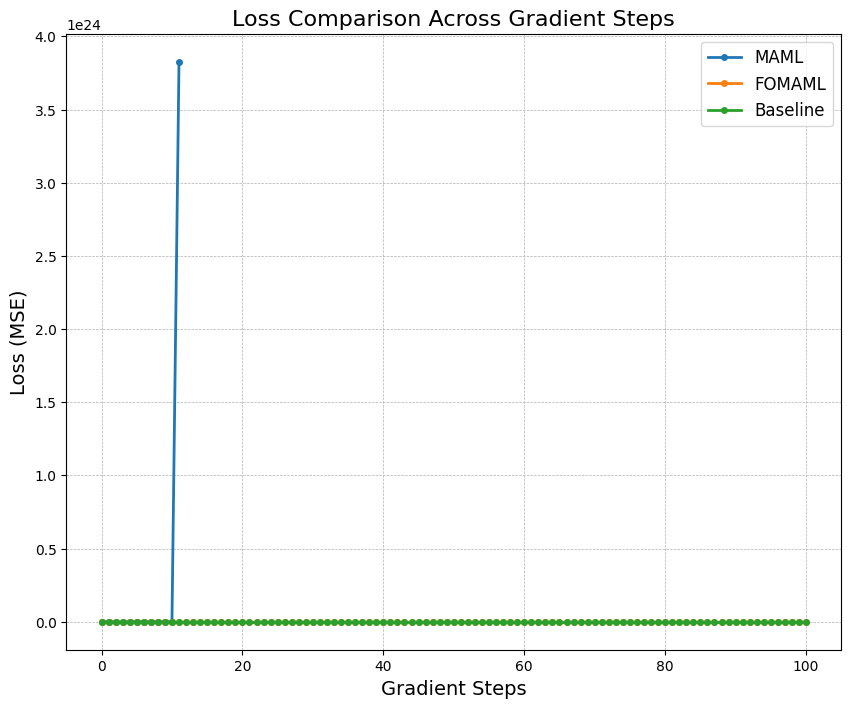

In [227]:
# Define the out of distribution task
def task(x):
    return 10 * tf.sin(x + 3/2 * np.pi)

# Generate training data points (xs, ys)
xs = tf.reshape(tf.linspace(-5., 5., 10), (10, 1))  # 10 sample points
ys = task(xs)

# Generate points for the true sine function
x = tf.reshape(tf.linspace(-5., 5., 1000), (1000, 1))  # 1000 points for plotting

# Define a custom loss function (Mean Squared Error)
loss_fn = tf.keras.losses.MeanSquaredError()

def compare_models(models, task, num_steps=200):
    """Compare the performance of different models on a given task over a number of gradient steps.
    
    Args:
        models: List of tuples (model_name, model_path) to evaluate.
        task: The task function to evaluate.
        num_steps: The number of gradient steps to perform.
        
    Returns:
        A dictionary mapping model names to their stepwise losses.
    """
    # Generate training data points (xs, ys)
    xs = tf.reshape(tf.linspace(-5., 5., 10), (10, 1))  # 10 sample points
    ys = task(xs)

    # Generate points for the true sine function
    x = tf.reshape(tf.linspace(-5., 5., 1000), (1000, 1))  # 1000 points for plotting

    # Results container
    all_losses = {}

    # Loop through each model
    for model_name, model_path in models:
        print(f"Evaluating {model_name}...")
        model = tf.keras.models.load_model(model_path)

        # Clone model to avoid overwriting weights
        copied_model = tf.keras.models.clone_model(model)
        copied_model.set_weights(model.get_weights())

        # Optimizer
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

        # Store losses at each step
        step_losses = []

        for step in range(num_steps + 1):
            # Compute loss on test data
            test_loss = loss_fn(task(x), copied_model(x)).numpy()
            step_losses.append(test_loss)

            # Perform a gradient step on training data
            if step < num_steps:
                with tf.GradientTape() as tape:
                    predictions = copied_model(xs)
                    loss = loss_fn(ys, predictions)
                gradients = tape.gradient(loss, copied_model.trainable_weights)
                optimizer.apply_gradients(zip(gradients, copied_model.trainable_weights))

        all_losses[model_name] = step_losses

    return all_losses

def plot_comparisons(losses_dict, num_steps=200):
    """Plot the stepwise losses for multiple models.
    
    Args:
        losses_dict: A dictionary mapping model names to their losses.
        num_steps: The number of gradient steps.
    """
    plt.figure(figsize=(10, 8))
    for model_name, losses in losses_dict.items():
        plt.plot(range(num_steps + 1), losses, label=model_name, marker='o', markersize=4, linewidth=2)
    
    plt.title("Loss Comparison Across Gradient Steps", fontsize=16)
    plt.xlabel("Gradient Steps", fontsize=14)
    plt.ylabel("Loss (MSE)", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

# Example usage
models = [
    ("MAML", "/home/kristmro/workspace/MetaLearningCodes/TestingSin/savedModels/maml-reproduce.keras"),
    ("FOMAML", "/home/kristmro/workspace/MetaLearningCodes/TestingSin/savedModels/fomaml-reproduce.keras"),
    ("Baseline", "/home/kristmro/workspace/MetaLearningCodes/TestingSin/savedModels/model.keras"),
]

# Compute losses
stepwise_losses = compare_models(models, task, num_steps=100)

# Plot the losses
plot_comparisons(stepwise_losses, num_steps=100)

Evaluating MAML...
Evaluating FOMAML...
Evaluating Baseline...


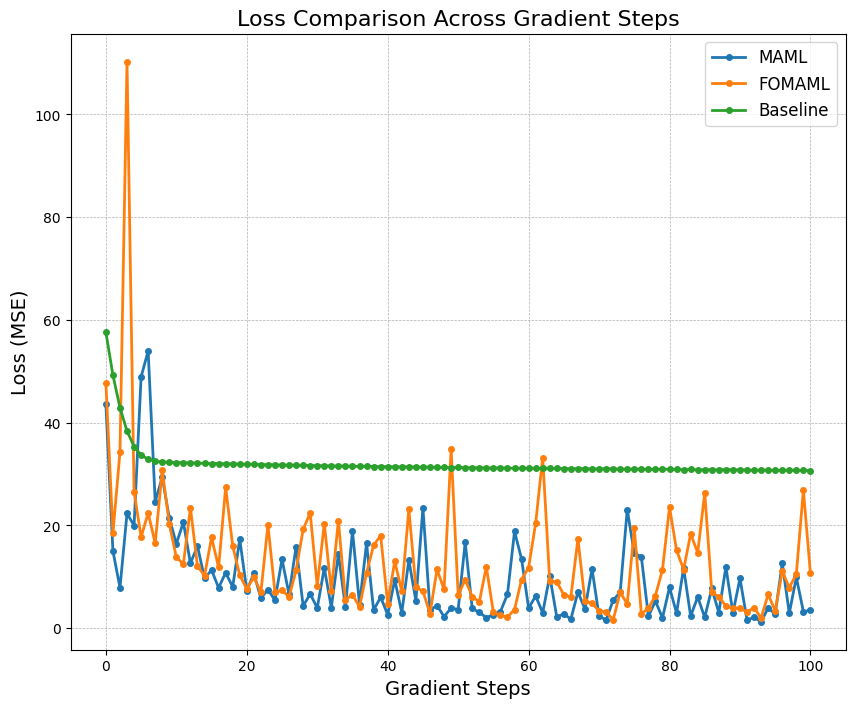

In [229]:

# Define the out of distribution task
def task(x):
    return 10 * tf.sin(x + 3/2 * np.pi)+2

# Generate training data points (xs, ys)
xs = tf.reshape(tf.linspace(-5., 5., 10), (10, 1))  # 10 sample points
ys = task(xs)

# Generate points for the true sine function
x = tf.reshape(tf.linspace(-5., 5., 1000), (1000, 1))  # 1000 points for plotting

# Define a custom loss function (Mean Squared Error)
loss_fn = tf.keras.losses.MeanSquaredError()

# Compute losses
stepwise_losses = compare_models(models, task, num_steps=100)

# Plot the losses
plot_comparisons(stepwise_losses, num_steps=100)